In [2]:
!pip install torch

    100% |████████████████████████████████| 519.5MB 34kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58fc2000 @  0x7f346596b1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


Mount Google Drive for access to data

In [0]:
import sys
from google.colab import auth
import getpass

if sys.platform == 'linux' and not 'initialized' in locals():
  !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
  !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
  !apt-get update -qq 2>&1 > /dev/null
  !apt-get -y install -qq google-drive-ocamlfuse fuse
  
  auth.authenticate_user()
  from oauth2client.client import GoogleCredentials
  creds = GoogleCredentials.get_application_default()

  !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
  vcode = getpass.getpass()
  !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

  !mkdir -p data
  !google-drive-ocamlfuse data
  
  initialized = True
else:
  print("Already initialized")

In [0]:
import torch
import numpy as np

torch.manual_seed(1);

In [0]:
class args:
  # data set sizes
  train_size = 10000
  test_size = 10000
  
  # training parameters
  n_iters = 5000
  print_every = 100
  plot_every = 50

  lr = 0.001
  
  # sampling
  max_length = 128

Initial boilerplate code

In [0]:
from collections import defaultdict

# Define vocabulary dictionary
next_index = 0
def get_new_index():
  global next_index
  index = next_index
  next_index += 1
  return index

vocabulary = defaultdict(get_new_index)

Load the phishing domains from a file. The file is expected to contain a pickled Python list of strings.

In [0]:
import pickle

TRAIN_FILE = "data/phishing_domains.dat"
with open(TRAIN_FILE, 'rb') as f:
    data = pickle.load(f)  

Tokenize data and fill (reverse) vocabulary

In [0]:
import itertools

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def tokenize(data):
  # Returns a list of Tensors, with each integer in the tensor representing a character in a domain name.
  # Note that domain names are case-insensitive.
  return [torch.tensor([vocabulary['<s>']] + [vocabulary[i] for i in domain.lower()] + [vocabulary['</s>']]).to(device) for domain in data]

def detokenize(t):
  # Recreate domain name from tensor 1d t
  res = ''
  for token in t:
    res += reverse_vocab[token.item()]
  return res

train_tokens = tokenize(data[:args.train_size])
test_tokens = tokenize(data[args.train_size:args.train_size+args.test_size])
  
vocab_size = len(vocabulary)
reverse_vocab = dict([(v,k) for k, v in vocabulary.items()])

Some helper functions

In [0]:
import numpy as np
import random

random.seed(1)

def one_hot(d):
  # One-hot encoding of 1-d tensor d
  res = torch.zeros(len(d), 1, vocab_size).to(device)
  for i, char in enumerate(d):
    res[i][0][int(char.item())] = 1
  return res

def encode_inputs(d):
  # One-hot encoding for the input of a 1d tensor
  return one_hot(d[:-1])

def encode_targets(d):
  # Return targets for 1d tensor d
  return d[1:]

def random_sample(data):
  return random.choice(data)


Define model

In [0]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(RNNModel, self).__init__()              
        self.n_hidden = n_hidden

        self.i2h = nn.Linear(n_input + n_hidden, n_hidden)
        self.i2o = nn.Linear(n_input + n_hidden, n_output)
        self.o2o = nn.Linear(n_hidden + n_output, n_output)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden=None):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
      return torch.zeros(1, self.n_hidden).to(device)
    
lossfn = nn.NLLLoss()

Define train function, which trains the provided model on a single domain name

In [0]:
def train_example(model, optimizer, sample):
  # train on a single example domain name
  inputs, targets = encode_inputs(sample), encode_targets(sample)

  hidden = model.init_hidden()
  targets.unsqueeze_(-1)
 
  loss = 0
    
  for i in range(inputs.size(0)):    
    input, target = inputs[i], targets[i]
    output, hidden = model(input, hidden)
    loss += lossfn(output, target)   

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
    
  return output, loss.item()/inputs.size(0)   

Util function for timing

In [0]:
import time
import math

def elapsed(since):
  # Return a string representing the elapsed time since 'since'
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

def now():
  return time.time()

Train the model

In [0]:
def train(model, optimizer):
  print_loss, plot_loss, all_losses = 0, 0, []  
  start = now()

  for iter in range(1, args.n_iters+1):
    sample = random_sample(train_tokens)  
    output, loss = train_example(model, optimizer, sample)
    print_loss += loss
    plot_loss += loss

    if iter % args.print_every == 0:    
      print("%s (%d %d%%) %.4f" % (elapsed(start), iter, iter/args.n_iters*100, print_loss / args.print_every))
      print_loss = 0

    if iter % args.plot_every == 0:
      avg_loss = plot_loss / args.plot_every
      all_losses.append(avg_loss)
      plot_loss = 0
      
  return all_losses

train_res = []

n_hidden = [128, 256]
for n in n_hidden:
  model = RNNModel(vocab_size, n, vocab_size).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
  
  model_losses = train(model, optimizer)
  
  train_res.append((model, n, model_losses))

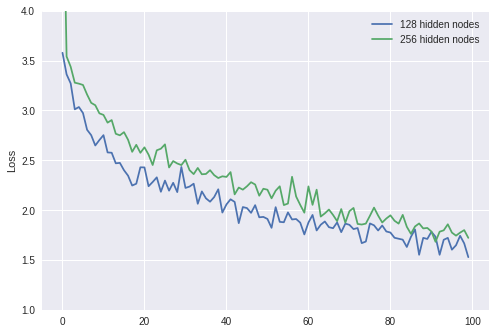

In [253]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
for model, n, model_losses in losses:
  line, = plt.plot(model_losses)
  line.set_label("%d hidden nodes" % n)
plt.legend()
plt.ylim(1, 4)
plt.ylabel("Loss");


Sample the network to generate domain names

In [263]:
def one_hot_letter(l):
  # One-hot encoding of letter
  return one_hot(torch.tensor([vocabulary[l]]))[0]

def sample(model, start_letter='<s>'):
  with torch.no_grad():
    input = one_hot_letter(start_letter)
    hidden = model.init_hidden()   

    res = '' if start_letter == '<s>' else start_letter
    
    for i in range(args.max_length):   
      output, hidden = model(input, hidden)
      predicted_num = output.topk(1)[1].item()
      if predicted_num == vocabulary['</s>']:
        # model generated an 'end-of-sequence'
        break
      predicted_letter = reverse_vocab[predicted_num]
      res += predicted_letter
      input = one_hot_letter(predicted_letter)    
      
    return res

def samples(model, start_letters=['<s>']):
  for start_letter in start_letters:
    print(sample(model, start_letter))

# generate 100 domain names
chars = 'abcdefghijklmnopqrstuvxyz0123456789'
for i in range(100):
  start_letter = random.choice(chars)
  print(sample(train_res[0][0], start_letter))
    

onet.net
rogi-bindse.com
4pay.allvin.com
zelindes.com
rogin.ingin.anm.812mbd5bisdevintinet
mate.compaypal.tk
xwww.linfarmo.com.iom.com
2120254bd3my850ywfrywww.www.lomforsdateb-lckerm.com
verinite.nivelwalesfasgong.com
quypal.mer-gicas.com
xwww.linfarmo.com.ant.cot
909121balct.comps-wolll.nor.motil.com
876.mots.mems-womntived.cor
x.com
serverisi.re
karde.ccounts.updrte.com
4paypal.cem.som
876.mot
9.moriveenfis.comer-pacot.motelitw.com
date.che.kesfarge-saccen-supps.tk
tedstones.co
terseccor-suspset
it.com
net.cet
z.net
verifacom.anm.com
dasecom.con.bon.set.com
serverise.com
line.com
j.com
matin.pactount.cod.kesuro.login-weblifasgom.com
876.mots.mems-web-paypa.do
876.mats.ckmpa.mousethechero.com
2120254bdyamp.com
quypa-dedm.wom
ypaltt.com
farmess.cor
yparte.com.bin.upd.com
j.com
hedaseccounto.net
ginet.com.net
onet.com
accounts.clvinw.bogl-sen-tcompessfarge-suris.com
esthe.com
55a2d.accus.ckm-arymares.com
dets.com
estinety.clonem.comes.com
verindia.bi
ypaltserveridi.aco.ve
ginet.cou
7.co